In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
path = "../AlgorithmABC/out/delim/"
data_path = "../data/"

country_list = ["AR", "AT", "BD", "BE", "BO", "BG", "CA", "CL", "CO", "EG", "FR", "GR", "DE", "GT",
                "HN", "HU", "ID", "IQ", "IE", "IL", "IT", "KW", "LU", "MY", "MX", "MA", "NG", "PK",
                "PA", "PH", "PL", "PT", "RO", "RU", "SA", "ZA", "ES", "CH", "TR", "US", "GB", "UA"]

priori = {
        'permeability':[0,1],
        'beta':[0.01, 0.30],
        # 'IFR':[0.002, 0.024],
        'xi':[1/18, 1/6],
        'init_days':[0,100],
        'delay':[2,20]}

params = list(priori.keys())

max_delay = priori['delay'][1]

In [3]:
def create_fatalities_lists(results):
    D = pd.Series(index=results['iter'].drop_duplicates(), dtype=object)
    for i in results['iter'].drop_duplicates():
        D.iloc[i] = pd.Series(results['D_sim'][i*ndays:i*ndays+ndays])
    return D

In [4]:
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)
country_badness = pd.Series(index=country_list, dtype=float)
for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])

    date_i, date_f = mobility.iloc[[0,-1]]['date']

    ndays = (pd.to_datetime(date_f) - pd.to_datetime(date_i)).days + 1


    try:
        values = pd.read_csv(path + f"values_{Country_code}.txt")
        results = pd.read_csv(path + f"results_{Country_code}.txt")
    except:
        continue

    D = pd.Series(index=results['iter'].drop_duplicates(), dtype=object)
    for i in results['iter'].drop_duplicates():
        D.iloc[i] = results['D_sim'][i*ndays:i*ndays+ndays]
    D = D.iloc[0:1]
    max_delay = priori['delay'][1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    max_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/(max_dead)
    country_badness.loc[Country_code] = badness
    
country_badness = country_badness.sort_values()

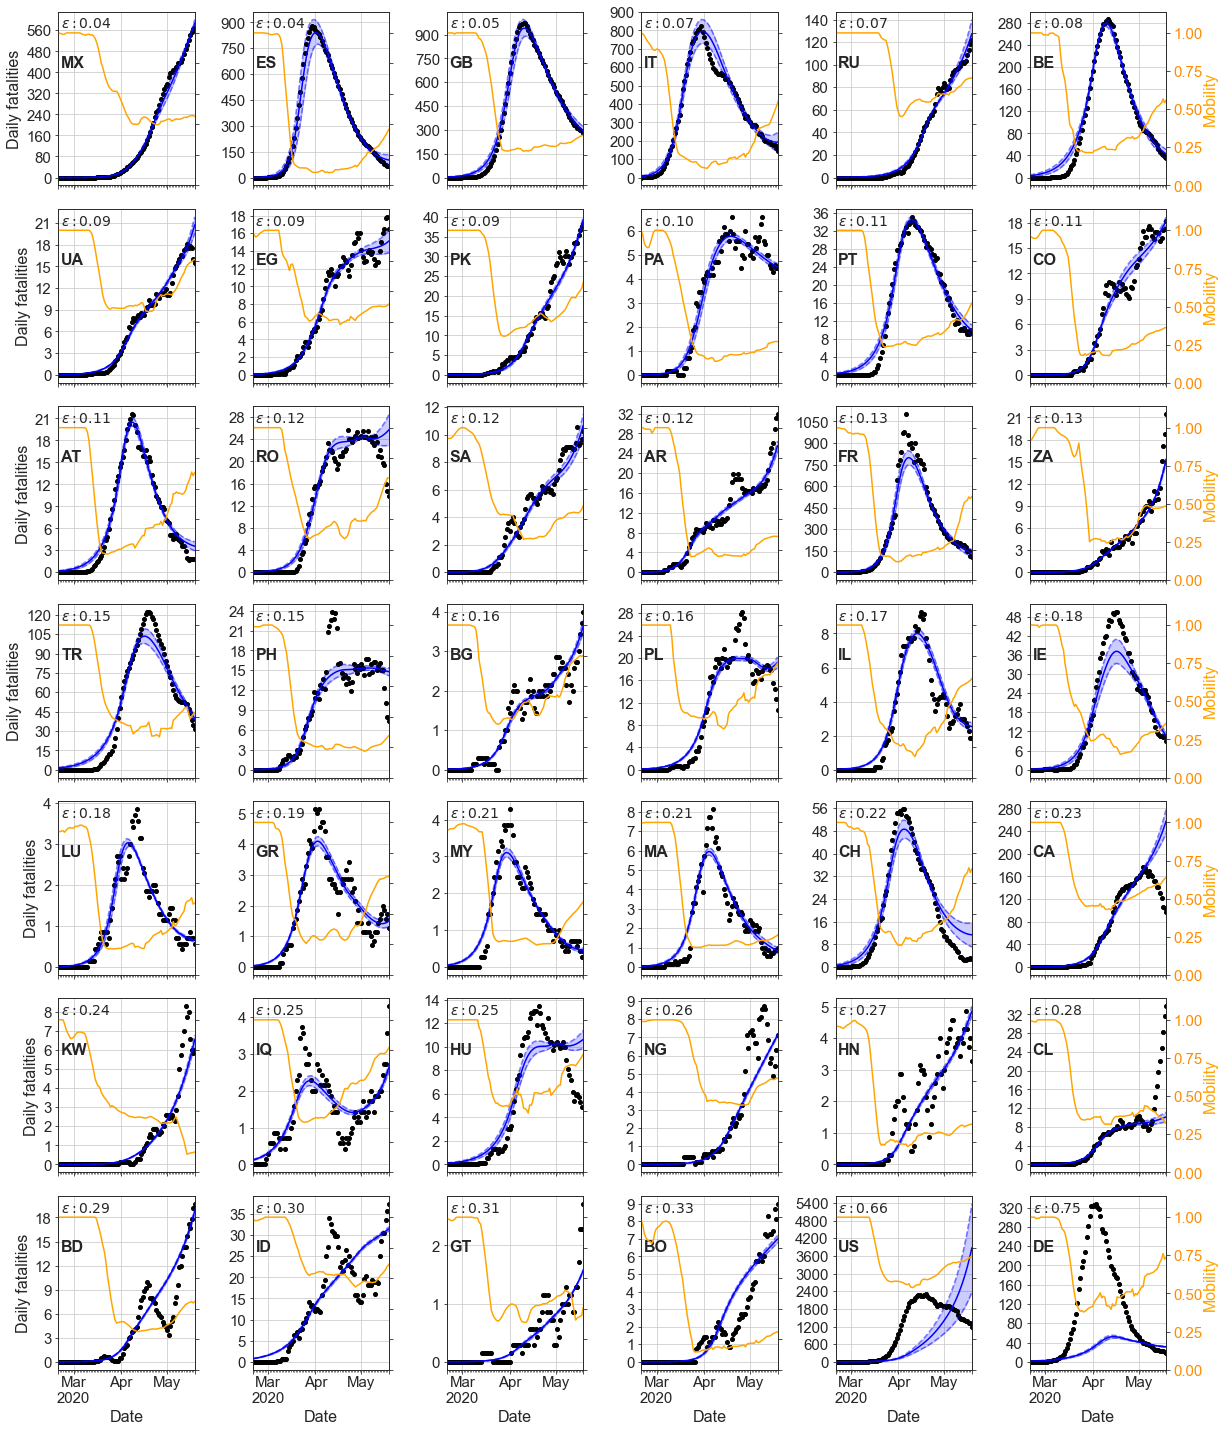

In [7]:
sns.set_style("ticks")

Country_code = 'ES'

rows = 7
cols = 6
fig,axes=plt.subplots(rows,cols,figsize=(17,20))
axes.size
for ax_index,Country_code in enumerate(country_badness.index):
    ax = axes[ax_index//cols,ax_index%cols]
    ax2 = ax.twinx()

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']

    ndays = (pd.to_datetime(date_f) - pd.to_datetime(date_i)).days + 1

    values = pd.read_csv(path + f"values_{Country_code}.txt")
    results = pd.read_csv(path + f"results_{Country_code}.txt")
    dead = pd.read_csv(path + f"dead_{Country_code}.txt")

    D = create_fatalities_lists(results).iloc[0:100]

    #average all the trajectories
    D_avg = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
    D_std = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
    for i in range(ndays-max_delay):
        #________________________________________________________________________________________________#######.iloc[i] if error
        cut_trajectory = [trajectory[max_delay - int(values.iloc[j]['delay']):ndays - int(values.iloc[j]['delay'])][i] for j,trajectory in enumerate(D)]
        D_avg.iloc[i] = np.mean(cut_trajectory)
        D_std.iloc[i] = np.std(cut_trajectory) * 1.96
    #plot the average trajectory

    #series of dates from 02-02-2020 to 02-05-2020
    dates1 = pd.date_range('2020-02-20', periods=ndays-max_delay, freq='D')

    D_avg.index=dates1
    D_std.index=dates1
    D_avg.plot(ax=ax, c='blue')
    (D_avg+D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
    (D_avg-D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
    ax.fill_between(dates1, (D_avg + D_std).astype(float).values, (D_avg - D_std).astype(float).values, color='blue', alpha=0.2)

    ax.scatter(dates1,dead_obs.iloc[max_delay:]['dead'], c='black', s=16)

    dates2 = pd.date_range('2020-02-01', periods=ndays, freq='D')
    ax2.plot(dates2, mobility['mobility'].values, c='orange')
    ax2.set_ylim(0,1.14)

    ax.tick_params(labelsize=15)
    ax.tick_params(axis='y',labelsize=15)
    #make yaxis integer numbers
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    if((ax_index%cols)==(cols-1)):
        ax2.tick_params(axis='y',labelsize=15, labelcolor='darkorange')
        ax2.set_ylabel('Mobility', fontsize=16, color='orange', labelpad=0.5)
    elif ((ax_index%cols)==0):
        ax.set_ylabel('Daily fatalities', fontsize=16)
        ax2.set_yticklabels([])
        ax2.set_ylabel('')
    else:
        ax.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.set_ylabel('')

    if((ax_index//cols)==(rows-1)):
        # ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(nbins=5))
        # ax.tick_params(axis='x', which='minor', labelsize=7, pad=0)
        ax.tick_params(axis='x', which='minor',labelbottom=False)
        ax.tick_params(axis='x', which='major', labelsize=15, pad=-30)
        ax.set_xlabel('Date', fontsize=16)
    else:
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

    ax.text(0.02, 0.75, Country_code, fontsize=16, fontweight='bold', va='top', ha='left', transform=ax.transAxes)
    ax.text(0.02, 0.97, f"$\epsilon:{country_badness[Country_code]:.2f}$", fontsize=14, va='top', ha='left', transform=ax.transAxes)

    ax.grid()

fig.tight_layout(h_pad=1.5, w_pad=1.4)

# fig.savefig('figures/fits.pdf', dpi=200, bbox_inches='tight')

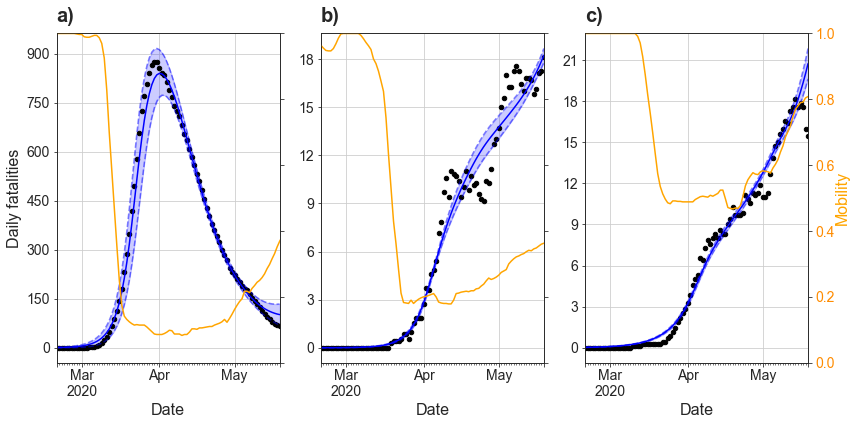

In [14]:
rows,cols = 1,3
labels = ['a)','b)','c)']
fig,axes=plt.subplots(rows,cols,figsize=(12,6))
axes.size
for ax_index,Country_code in enumerate(['ES','CO','UA']):
    ax = axes[ax_index]
    ax2 = ax.twinx()

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']

    ndays = (pd.to_datetime(date_f) - pd.to_datetime(date_i)).days + 1


    values = pd.read_csv(path + f"values_{Country_code}.txt")
    results = pd.read_csv(path + f"results_{Country_code}.txt")
    dead = pd.read_csv(path + f"dead_{Country_code}.txt")


    D = pd.Series(index=results['iter'].drop_duplicates(), dtype=object)
    for i in results['iter'].drop_duplicates():
        D.iloc[i] = pd.Series(results['D_sim'][i*ndays:i*ndays+ndays])

    D = D.iloc[0:100]

    #average all the trajectories
    D_avg = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
    D_std = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
    for i in range(ndays-max_delay):
        cut_trajectory = [trajectory[max_delay - int(values.iloc[j]['delay']):ndays - int(values.iloc[j]['delay'])][i] for j,trajectory in enumerate(D)]
        D_avg.iloc[i] = np.mean(cut_trajectory)
        D_std.iloc[i] = np.std(cut_trajectory) * 1.96
    #plot the average trajectory

    #series of dates from 02-02-2020 to 02-05-2020
    dates1 = pd.date_range('2020-02-20', periods=ndays-max_delay, freq='D')

    D_avg.index=dates1
    D_std.index=dates1
    D_avg.plot(ax=ax, c='blue')
    (D_avg+D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
    (D_avg-D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
    ax.fill_between(dates1, (D_avg + D_std).astype(float).values, (D_avg - D_std).astype(float).values, color='blue', alpha=0.2)

    ax.scatter(dates1,dead_obs.iloc[max_delay:]['dead'], c='black', s=20)

    dates2 = pd.date_range('2020-02-01', periods=ndays, freq='D')
    ax2.plot(dates2, mobility['mobility'].values, c='orange')
    ax2.set_ylim(0,1)

    ax.tick_params(labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    #make yaxis integer numbers
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    if((ax_index%cols)==(cols-1)):
        ax2.tick_params(axis='y',labelsize=14, labelcolor='darkorange')
        ax2.set_ylabel('Mobility', fontsize=16, color='orange', labelpad=0)
    elif ((ax_index%cols)==0):
        ax.set_ylabel('Daily fatalities', fontsize=16)
        ax2.set_yticklabels([])
        ax2.set_ylabel('')
    else:
        ax.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.set_ylabel('')

    # ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(nbins=5))
    # ax.tick_params(axis='x', which='minor', labelsize=7, pad=0)
    ax.tick_params(axis='x', which='minor',labelbottom=False)
    ax.tick_params(axis='x', which='major', labelsize=14, pad=-30)
    ax.set_xlabel('Date', fontsize=16)

    ax.text(0, 1.08, labels[ax_index], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top')

    ax.grid()

fig.tight_layout(h_pad=1.5, w_pad=1.5)

# fig.savefig('figures/fits/ES_CO_UA.pdf', dpi=200, bbox_inches='tight')